In [2]:
molecule = [
    ("H2", [0.5]),
    ("H2", [0.54]),
    ("H2", [0.58]),
    ("H2", [0.62]),
    ("H2", [0.66]),
    ("H2", [0.82]),
    ("H2", [0.86]),
    ("H2", [0.9]),
    ("H2", [0.94]),
    ("H2", [0.98]),
    ("H2", [1.02]),
    ("H2", [1.06]),
    ("H2", [1.1]),
    ("H2", [1.14]),
    ("H2", [1.18]),
    ("H2", [1.22]),
    ("H2", [1.26]),
    ("H2", [1.3]),
    ("H2", [1.34]),
    ("H2", [1.38]),
    ("H2", [1.42]),
    ("H2", [1.46]),
    ("H2", [1.5]),
    ("H2", [1.54]),
    ("H2", [1.58]),
    ("H2", [1.62]),
    ("H2", [1.66]),
    ("H2", [1.7]),
    ("H2", [1.74]),
    ("H2", [1.78]),
    ("H2", [1.82]),
    ("H2", [1.86]),
    ("H2", [1.9]),
    ("H2", [1.94]),
    ("H2", [1.98]),
    ("H2", [2.02]),
    ("H2", [2.06]),
    ("H2", [2.1]),
    ("H3+", [0.5]),
    ("H3+", [0.54]),
    ("H3+", [0.58]),
    ("H3+", [0.62]),
    ("H3+", [0.66]),
    ("H3+", [0.7]),
    ("H3+", [0.74]),
    ("H3+", [0.78]),
    ("H3+", [0.82]),
    ("H3+", [0.86]),
    ("H3+", [0.9]),
    ("H3+", [0.94]),
    ("H3+", [0.98]),
    ("H3+", [1.02]),
    ("H3+", [1.06]),
    ("H3+", [1.1]),
    ("H3+", [1.14]),
    ("H3+", [1.18]),
    ("H3+", [1.22]),
    ("H3+", [1.26]),
    ("H3+", [1.3]),
    ("H3+", [1.34]),
    ("H3+", [1.38]),
    ("H3+", [1.42]),
    ("H3+", [1.46]),
    ("H3+", [1.5]),
    ("H3+", [1.54]),
    ("H3+", [0.5]),
    ("H2", None),
    ("H3+", None),
    ("H4", None)

]

In [1]:
!pip install pennylane
!pip install aiohttp fsspec h5py
!pip install pennylane-lightningimport numpy as np
import pandas as pd
import pennylane as qml
from pennylane import qchem
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import minimize
import optax
import jax
import jax.numpy as jnp
from jax import random
import h5py
import os
import logging
import time
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pennylane-lightningimport (from versions: none)
ERROR: No matching distribution found for pennylane-lightningimport


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
def load_data(molecule, basis="STO-3G"):
  data_list = []

  for mol,bondlengths in molecule:
    # If bondlengths is None, load default bond length
    if bondlengths is None:
      data = qml.data.load("qchem", molname=mol, basis=basis)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    else:
      # Otherwise, iterate over the bond lengths
      data = qml.data.load("qchem", molname=mol, basis=basis, bondlength=bondlengths)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    for entry in data:
      data_list.append(entry)

  df = pd.DataFrame(data_list)
  return df

# Input molecule data
# HeH2 only has 6-31G, also, C2H6, CO2, N2H4, C2H4, N2H2, CH2O, C2H2 no data
# molecule = ["LiH", "Li2", "N2", "CO2", "BH3", "H2O2", "O2", "CO", "C2", "H4", "BeH2", "H3+", "NH3", "H2O",
            #"CH4", "HeH+", "H8", "H10", "NeH+", "OH-", "H6", "HF", "H2"]

In [4]:
def electrons_and_orbitals(hf_state):
  electrons = sum(hf_state)
  orbitals = int(len(hf_state))

  return electrons, orbitals

def max_params (dataset):
  max_s_wires = 0
  max_d_wires = 0

  for data in dataset:
    electrons, orbitals = electrons_and_orbitals(data.hf_state)

    single, double = qchem.excitations(electrons, orbitals)
    s_w, d_w = qml.qchem.excitations_to_wires(single, double)
    single = len(s_w)
    double = len(d_w)
    max_s_wires = max(max_s_wires, single)
    max_d_wires = max(max_d_wires, double)

  return max_s_wires, max_d_wires

In [39]:
class DenseLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=False):
        super(DenseLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=use_bias)

    def forward(self, x):
        return self.linear(x)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(LSTMLayer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, x, hidden=None):
        if hidden is None:
            batch_size = x.size(0)
            h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            hidden = (h0, c0)
        output, (hn, cn) = self.lstm(x, hidden)
        return output, hn, cn

In [6]:
def vqe_molecule_u(data, max_qubits):
    wires = range(max_qubits)
    orbitals = len(data.hf_state)
    electrons = sum(data.hf_state)
    single_wires, double_wires = qchem.excitations(electrons, orbitals)
    s_wires, d_wires = qml.qchem.excitations_to_wires(single_wires, double_wires)

    num_single = len(s_wires)
    num_double = len(d_wires)

    single_mapping = DenseLayer(fixed_param_dim // 2, num_single, use_bias=False)
    double_mapping = DenseLayer(fixed_param_dim // 2, num_double, use_bias=False)

    def circuit(params, wires):
        params = params.view(-1)
        half_dim = fixed_param_dim // 2
        single_input = params[:half_dim]
        double_input = params[half_dim:]

        single_params_full = single_mapping(single_input.unsqueeze(0)).squeeze(0)
        double_params_full = double_mapping(double_input.unsqueeze(0)).squeeze(0)

        single_params = single_params_full[:num_single]
        double_params = double_params_full[:num_double]

        mapped_params = torch.cat([single_params, double_params], dim=0)

        qml.UCCSD(mapped_params, range(orbitals), s_wires, d_wires, data.hf_state)

        return qml.expval(data.hamiltonian)

    def hamiltonian_cost(params, **kwargs):
        dev = qml.device("lightning.qubit", wires=wires)
        cost = qml.QNode(circuit, dev, diff_method="adjoint", interface="torch")
        return cost(params, wires=wires)

    return hamiltonian_cost

In [50]:
def vqe_optimization(molecule_cost, initial_params, max_iter=10, learning_rate=0.1, conv_tol=1e-6, optimizer="ADAM"):
    params = torch.tensor(initial_params, requires_grad=True, dtype=torch.float32)

    if optimizer == "ADAM":
        opt = optim.Adam([params], lr=learning_rate)
    elif optimizer == "SGD":
        opt = optim.SGD([params], lr=learning_rate)

    energy_history = [molecule_cost(params).item()]
    param_history = [params.detach().clone()]
    conv_iter = max_iter

    for iteration in range(max_iter):
        opt.zero_grad()
        cost = molecule_cost(params)
        cost.backward()
        opt.step()

        param_history.append(params.detach().clone())
        energy_history.append(cost.item())



        if iteration % 50 == 0:
            print(f"Step = {iteration+1}/{max_iter}, Energy= {energy_history[-1]:.8f} Ha")

        if iteration > 0 :
          conv = abs(energy_history[-1] - energy_history[-2])
          if conv <= conv_tol:
            conv_iter = iteration + 1
            break

    return conv_iter, param_history[-1], energy_history[-1], param_history, energy_history

In [42]:
def rnn_iteration_u(inputs, molecule_cost, rnn_layer, single_mapping, double_mapping):

    prev_cost, prev_params, prev_h, prev_c = inputs

    new_input = torch.cat([prev_cost, prev_params], dim=1)
    new_input = new_input.unsqueeze(1)

    outputs, new_h, new_c = rnn_layer(new_input, (prev_h, prev_c))
    new_params = outputs.squeeze(1)

    _cost = molecule_cost(new_params)
    new_cost = _cost.view(1, 1).float()

    return [new_cost, new_params, new_h, new_c]

def recurrent_loop_u(molecule_cost, steps=5, LossFunction="weighted", intermediate_steps=False, rnn_layer=None, single_mapping=None, double_mapping=None):
    initial_cost = torch.zeros((1, 1), dtype=torch.float32)
    initial_params = torch.zeros((1, fixed_param_dim), dtype=torch.float32)
    initial_h = torch.zeros((rnn_layer.num_layer, 1, fixed_param_dim), dtype=torch.float32)
    initial_c = torch.zeros((rnn_layer.num_layer, 1, fixed_param_dim), dtype=torch.float32)

    inputs = [initial_cost, initial_params, initial_h, initial_c]
    param_outputs = []
    cost_outputs = []

    for _ in range(steps):
        inputs = rnn_iteration_u(inputs, molecule_cost, rnn_layer, single_mapping, double_mapping)
        param_outputs.append(inputs[1])
        cost_outputs.append(inputs[0])

    loss = 0.0

    if LossFunction == "weighted":
        for t in range(len(cost_outputs)):
            coeff = 0.1 * (t + 1)
            loss += cost_outputs[t] * coeff
        loss = loss / len(cost_outputs)

    elif LossFunction == "descent":
        min_cost = cost_outputs[0]
        for t in range(1, len(cost_outputs)):
            min_cost_j = cost_outputs[t-1]
            for j in range(t):
                if cost_outputs[j] < min_cost_j:
                    min_cost_j = cost_outputs[j]
            loss += cost_outputs[t] - min_cost_j

    if intermediate_steps:
        return param_outputs + [loss]
    else:
        return loss

def train_step_u(molecule_cost, LossFunction="weighted", steps=10, rnn_layer=None, single_mapping=None, double_mapping=None, optimizer=None):
    optimizer.zero_grad()
    loss = recurrent_loop_u(molecule_cost, steps=steps, LossFunction=LossFunction, rnn_layer=rnn_layer, single_mapping=single_mapping, double_mapping=double_mapping)
    loss.backward()
    optimizer.step()
    return loss

In [9]:
dataset = load_data(molecule, basis="STO-3G")
print(dataset.head())

                                                   0
0  <Dataset = molname: H2, basis: STO-3G, bondlen...
1  <Dataset = molname: H2, basis: STO-3G, bondlen...
2  <Dataset = molname: H2, basis: STO-3G, bondlen...
3  <Dataset = molname: H2, basis: STO-3G, bondlen...
4  <Dataset = molname: H2, basis: STO-3G, bondlen...


In [10]:
max_qubits = 0

for i in range(len(dataset[0])):
  if len(dataset[0][i].hf_state) > max_qubits:
    max_qubits = len(dataset[0][i].hf_state)

print(max_qubits)

8


In [11]:
dataset_list = list(dataset[0])
train_set = dataset_list[:68]
test_set = dataset_list[68]
print(f"train set: {train_set}")
print(f"test set: {test_set}")

train set: [<Dataset = molname: H2, basis: STO-3G, bondlength: 0.5, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.54, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.58, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.62, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.66, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.82, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.86, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.9, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.94, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.98, attributes: ['molname', 'basis', ...]>, <Dataset = molname: 

In [12]:
max_s_params, max_d_params = max_params(dataset[0])
print(f"the number of max single wires: {max_s_params}")
print(f"the number of max double wires: {max_d_params}")

the number of max single wires: 8
the number of max double wires: 18


In [27]:
max_s_params, max_d_params = max_params(dataset[0])
fixed_param_dim = 40
single_mapping = DenseLayer(fixed_param_dim // 2, max_s_params, use_bias=False)
double_mapping = DenseLayer(fixed_param_dim // 2, max_d_params, use_bias=False)
rnn_layer = LSTMLayer(fixed_param_dim + 1, fixed_param_dim, num_layer = 1)

In [45]:
molecule_cost_list_u = [vqe_molecule_u(m, max_qubits) for m in train_set]

opt_u = optim.Adam(list(rnn_layer.parameters()) + list(single_mapping.parameters()) + list(double_mapping.parameters()), lr=0.1)

epochs_u = 5
steps_per_epoch_u = 5
previous_mean_loss_u = None

for epoch in range(epochs_u):
    start_time = time.time()

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_u}")

    epoch_loss_u = []
    for i, molecule_cost in enumerate(molecule_cost_list_u):
        loss = train_step_u(molecule_cost, LossFunction="weighted", steps=steps_per_epoch_u, rnn_layer=rnn_layer, single_mapping=single_mapping, double_mapping=double_mapping, optimizer=opt_u)
        epoch_loss_u.append(loss.item())

        if i % 10 == 0:
            print(f" > Molecule {i+1}/{len(molecule_cost_list_u)} - Loss: {loss.item():.8f}")
            print(f" > steps_per_epoch: {steps_per_epoch_u}")

    epoch_loss_u = np.array(epoch_loss_u)
    mean_loss_u = np.mean(epoch_loss_u)

    if epoch % 10 == 0:
        print(f" > Mean loss: {mean_loss_u:.6f}")

    if mean_loss_u > 1e-2:
        steps_per_epoch_u = min(steps_per_epoch_u + 2, 15)
    elif mean_loss_u < 1e-3:
        steps_per_epoch_u = max(steps_per_epoch_u - 2, 5)

    if previous_mean_loss_u is not None:
        rel_change = (previous_mean_loss_u - mean_loss_u) / (abs(previous_mean_loss_u))
        if rel_change <= 1e-4:
            print(f"Training Converged at Epoch {epoch+1}")
            break

    previous_mean_loss = mean_loss_u

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time of train for {epoch+1}: {execution_time:.1f} seconds")

Epoch 1/5
 > Molecule 1/68 - Loss: -0.31238329
 > steps_per_epoch: 5
 > Molecule 11/68 - Loss: -0.32367399
 > steps_per_epoch: 5
 > Molecule 21/68 - Loss: -0.29034945
 > steps_per_epoch: 5
 > Molecule 31/68 - Loss: -0.23645806
 > steps_per_epoch: 5
 > Molecule 41/68 - Loss: -0.28826740
 > steps_per_epoch: 5
 > Molecule 51/68 - Loss: -0.37409794
 > steps_per_epoch: 5
 > Molecule 61/68 - Loss: -0.34787321
 > steps_per_epoch: 5
 > Mean loss: -0.308041
Execution time of train for 1: 62.8 seconds
 > Molecule 1/68 - Loss: -0.31293857
 > steps_per_epoch: 5
 > Molecule 11/68 - Loss: -0.31839952
 > steps_per_epoch: 5
 > Molecule 21/68 - Loss: -0.28019193
 > steps_per_epoch: 5
 > Molecule 31/68 - Loss: -0.24543777
 > steps_per_epoch: 5
 > Molecule 41/68 - Loss: -0.28668129
 > steps_per_epoch: 5
 > Molecule 51/68 - Loss: -0.37415165
 > steps_per_epoch: 5
 > Molecule 61/68 - Loss: -0.34755284
 > steps_per_epoch: 5
Execution time of train for 2: 59.5 seconds
 > Molecule 1/68 - Loss: -0.31286791
 > 

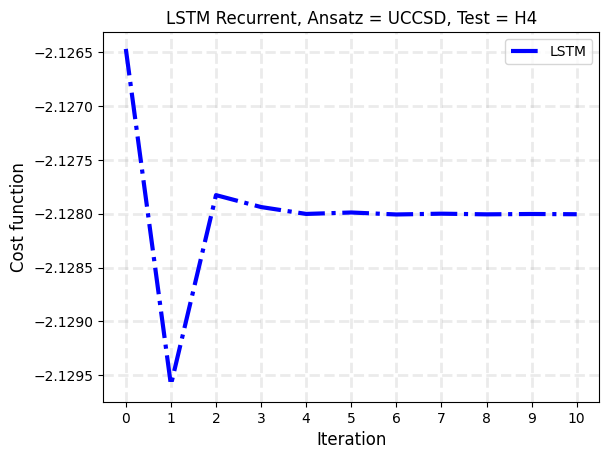

In [47]:
test_molecule_cost_u = vqe_molecule_u(test_set, max_qubits)

res = recurrent_loop_u(
    test_molecule_cost_u,
    steps=10,
    LossFunction="weighted",
    intermediate_steps=True,
    rnn_layer=rnn_layer,
    single_mapping=single_mapping,
    double_mapping=double_mapping
)

start_zeros = torch.zeros(fixed_param_dim)
guesses = [start_zeros] + [
    torch.reshape(r, (1, fixed_param_dim)) for r in res[:-1]
]

# Extract final loss
final_loss = res[-1]

# Compute LSTM losses
lstm_losses_u = [
    test_molecule_cost_u(torch.reshape(guess, (1, fixed_param_dim))).item()
    for guess in guesses
]

# Plot results
fig, ax = plt.subplots()

plt.plot(lstm_losses_u, color="blue", lw=3, ls="-.", label="LSTM")
plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.title("LSTM Recurrent, Ansatz = UCCSD, Test = H4")
plt.legend()
ax.set_xticks(range(0, len(lstm_losses_u)))
plt.show()

In [51]:
conv_iter_u_adam, lstm_optimized_params_u_adam, lstm_optimized_energy_u_adam, lstm_param_history_u_adam, lstm_energy_history_u_adam = vqe_optimization(
    test_molecule_cost_u,
    initial_params=guesses[-1],
    max_iter=500,
    learning_rate=0.1,
    conv_tol = 1e-6,
    optimizer = "ADAM"
)

<ipython-input-50-2147625519>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad=True, dtype=torch.float32)


Step = 1/500, Energy= -2.12800479 Ha
Step = 51/500, Energy= -2.18027377 Ha


In [53]:
lstm_optimized_energy_u_adam

-2.180323600769043